# 02 - Data from the Web

## Deadline
Wednesday October 25, 2017 at 11:59PM

## Important Notes
* Make sure you push on GitHub your Notebook with all the cells already evaluated (i.e., you don't want your colleagues to generate unnecessary Web traffic during the peer review)
* Don't forget to add a textual description of your thought process, the assumptions you made, and the solution you plan to implement!
* Please write all your comments in English, and use meaningful variable names in your code.

## Background
In this homework we will extract interesting information from www.topuniversities.com and www.timeshighereducation.com, two platforms that maintain a global ranking of worldwide universities. This ranking is not offered as a downloadable dataset, so you will have to find a way to scrape the information we need!
You are not allowed to download manually the entire ranking -- rather you have to understand how the server loads it in your browser. For this task, Postman with the Interceptor extension can help you greatly. We recommend that you watch this [brief tutorial](https://www.youtube.com/watch?v=jBjXVrS8nXs&list=PLM-7VG-sgbtD8qBnGeQM5nvlpqB_ktaLZ&autoplay=1) to understand quickly how to use it.

## Assignment
1. Obtain the 200 top-ranking universities in www.topuniversities.com ([ranking 2018](https://www.topuniversities.com/university-rankings/world-university-rankings/2018)). In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the [details page](https://www.topuniversities.com/universities/ecole-polytechnique-fédérale-de-lausanne-epfl).
Store the resulting dataset in a pandas DataFrame and answer the following questions:
- Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?
- Answer the previous question aggregating the data by (c) country and (d) region.

Plot your data using bar charts and describe briefly what you observed.

2. Obtain the 200 top-ranking universities in www.timeshighereducation.com ([ranking 2018](http://timeshighereducation.com/world-university-rankings/2018/world-ranking)). Repeat the analysis of the previous point and discuss briefly what you observed.

3. Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.

4. Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

5. Can you find the best university taking in consideration both rankings? Explain your approach.

Hints:
- Keep your Notebook clean and don't print the verbose output of the requests if this does not add useful information for the reader.
- In case of tie, use the order defined in the webpage.


# Solution

## Question 1
First let's try to do the request on the https://www.topuniversities.com/university-rankings/world-university-rankings/2018 url just to see what we get.

In [1]:
import requests
from bs4 import BeautifulSoup

In [2]:
r = requests.get('https://www.topuniversities.com/university-rankings/world-university-rankings/2018')
soup = BeautifulSoup(r.text, 'html.parser')
soup

<!DOCTYPE html>

<html dir="ltr" version="XHTML+RDFa 1.0" xml:lang="en" xmlns="http://www.w3.org/1999/xhtml" xmlns:article="http://ogp.me/ns/article#" xmlns:book="http://ogp.me/ns/book#" xmlns:content="http://purl.org/rss/1.0/modules/content/" xmlns:dc="http://purl.org/dc/terms/" xmlns:foaf="http://xmlns.com/foaf/0.1/" xmlns:og="http://ogp.me/ns#" xmlns:product="http://ogp.me/ns/product#" xmlns:profile="http://ogp.me/ns/profile#" xmlns:rdfs="http://www.w3.org/2000/01/rdf-schema#" xmlns:schema="http://schema.org/" xmlns:sioc="http://rdfs.org/sioc/ns#" xmlns:sioct="http://rdfs.org/sioc/types#" xmlns:skos="http://www.w3.org/2004/02/skos/core#" xmlns:video="http://ogp.me/ns/video#" xmlns:xsd="http://www.w3.org/2001/XMLSchema#">
<head profile="http://www.w3.org/1999/xhtml/vocab">
<meta content="unsafe-url" name="referrer"/>
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/><script type="text/javascript">(window.NREUM||(NREUM={})).loader_config={xpid:"UwUCVVVTGwIAV1VXBQkP"}

If we do Ctrl+F and try to look for "Imperial College London" for example, we don't get anything in the Beautifoul soup HTML even if the string is clearly on the webpage. This is because the data is not loaded at the beginning when the HTML request is answered. It is loaded later and the ranking data is in a separate file. Using Google Chrome Interceptor we figured out the file is at https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051_indicators.txt. So this is the webpage we will scrape instead of the ranking webpage:

In [3]:
from html import parser
import os

In [4]:
base_url = 'https://www.topuniversities.com/'

# create a subclass and override the handler methods
class QSHTMLParser(parser.HTMLParser):
    def handle_starttag(self, tag, attrs):
        if not hasattr(self, 'array_hrefs'):
            self.array_hrefs = []
        if tag == 'a':
            self.last_tag_url = os.path.join(base_url, attrs[0][1][1:])
            
    def handle_data(self, data):
        self.array_hrefs.append({"url": self.last_tag_url, "name": data})

In [5]:
request_ranking_text_file = requests.get('https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051_indicators.txt')

In [6]:
# We want to keep track of this for the other ranking where there is no region information:
location_region_dict = {}

json_ranking = request_ranking_text_file.json()
ranking_data = json_ranking['data'][:200]
parser = QSHTMLParser()
for university in ranking_data:
    parser.feed(university['uni'])
    
basic_data = parser.array_hrefs
for i, university in enumerate(ranking_data):
    curr_uni = basic_data[i]
    curr_uni['region'] = university['region']
    curr_uni['location'] = university['location']
    curr_uni['rank'] = university['overall_rank']
    if university['location'] not in location_region_dict:
        location_region_dict[university['location']] = university['region']
basic_data[0:12]

[{'location': 'United States',
  'name': 'Massachusetts Institute of Technology (MIT) ',
  'rank': '1',
  'region': 'North America',
  'url': 'https://www.topuniversities.com/universities/massachusetts-institute-technology-mit'},
 {'location': 'United States',
  'name': 'Stanford University',
  'rank': '2',
  'region': 'North America',
  'url': 'https://www.topuniversities.com/universities/stanford-university'},
 {'location': 'United States',
  'name': 'Harvard University',
  'rank': '3',
  'region': 'North America',
  'url': 'https://www.topuniversities.com/universities/harvard-university'},
 {'location': 'United States',
  'name': 'California Institute of Technology (Caltech)',
  'rank': '4',
  'region': 'North America',
  'url': 'https://www.topuniversities.com/universities/california-institute-technology-caltech'},
 {'location': 'United Kingdom',
  'name': 'University of Cambridge',
  'rank': '5',
  'region': 'Europe',
  'url': 'https://www.topuniversities.com/universities/universi

Now we have the URLs of the first 200 universities. Let's take a closer look et the EPFL detail page:

In [7]:
import re

In [8]:
url_epfl = basic_data[11]['url']
request_epfl = requests.get(url_epfl)
soup_epfl = BeautifulSoup(request_epfl.text, 'html.parser')
div_details = soup_epfl.find_all('div', {"class": "view-academic-data-profile"})[0]
div_details.find_all('div', {"class": "number"})
test_det = div_details.find_all('div', {"class": "number"})
student_values = ["staff_total", "staff_international", "students_total", "students_international"]
number_students = {}
for i in range(0, 4):
    number = int(re.sub('[,]', '', test_det[i].get_text()))
    number_students[student_values[i]] = number
number_students

{'staff_international': 1300,
 'staff_total': 1695,
 'students_international': 5896,
 'students_total': 10343}

That's it, the code is maybe a little messy but with some browser inspection we can figure out where the things we need on the EPFL webpage are.
Now let us generalize this to all the 50 first universities:

In [9]:
number_students_per_fac = {}
student_values = ["staff_total", "staff_international", "students_total", "students_international"]
for i, data in enumerate(basic_data):
    url = data['url']
    # print("Processing ", i, ": ", url)
    request_uni = requests.get(url)
    soup_uni = BeautifulSoup(request_uni.text, 'html.parser')
    div_details = soup_uni.find_all('div', {"class": "view-academic-data-profile"})[0]
    test_det = div_details.find_all('div', {"class": "number"})
    number_students = {}
    if len(test_det) == 4:
        for j in range(0, 4):
            number = int(re.sub('[,]', '', test_det[j].get_text()))
            basic_data[i][student_values[j]] = number
            
    number_students_per_fac[url] = number_students

In [10]:
basic_data[0:4]

[{'location': 'United States',
  'name': 'Massachusetts Institute of Technology (MIT) ',
  'rank': '1',
  'region': 'North America',
  'staff_international': 1679,
  'staff_total': 2982,
  'students_international': 3717,
  'students_total': 11067,
  'url': 'https://www.topuniversities.com/universities/massachusetts-institute-technology-mit'},
 {'location': 'United States',
  'name': 'Stanford University',
  'rank': '2',
  'region': 'North America',
  'staff_international': 2042,
  'staff_total': 4285,
  'students_international': 3611,
  'students_total': 15878,
  'url': 'https://www.topuniversities.com/universities/stanford-university'},
 {'location': 'United States',
  'name': 'Harvard University',
  'rank': '3',
  'region': 'North America',
  'staff_international': 1311,
  'staff_total': 4350,
  'students_international': 5266,
  'students_total': 22429,
  'url': 'https://www.topuniversities.com/universities/harvard-university'},
 {'location': 'United States',
  'name': 'California In

That's it, we have all the data for the number of students. We can convince ourselves that this is right by taking a university at random and visiting the corresponding webpage (if we take more of them the probability that our results our wrong decrease exponentially).

Now we simply construct our dataframe (omitting the urls) and set the rank as the key:

In [11]:
import pandas as pd

In [12]:
basic_data_without_url = [dict(uni) for uni in basic_data]
for uni in basic_data_without_url:
    del uni["url"]

qs_dataframe = pd.DataFrame.from_dict(basic_data_without_url)
qs_dataframe

,location,name,rank,region,staff_international,staff_total,students_international,students_total
0,United States,Massachusetts Institute of Technology (MIT),1,North America,1679.0,2982.0,3717.0,11067.0
1,United States,Stanford University,2,North America,2042.0,4285.0,3611.0,15878.0
2,United States,Harvard University,3,North America,1311.0,4350.0,5266.0,22429.0
3,United States,California Institute of Technology (Caltech),4,North America,350.0,953.0,647.0,2255.0
4,United Kingdom,University of Cambridge,5,Europe,2278.0,5490.0,6699.0,18770.0
5,United Kingdom,University of Oxford,6,Europe,2964.0,6750.0,7353.0,19720.0
6,United Kingdom,UCL (University College London),7,Europe,2554.0,6345.0,14854.0,31080.0
7,United Kingdom,Imperial College London,8,Europe,2071.0,3930.0,8746.0,16090.0
8,United States,University of Chicago,9,North America,635.0,2449.0,3379.0,13557.0
9,Switzerland,ETH Zurich - Swiss Federal Institute of Techno...,10,Europe,1886.0,2477.0,7563.0,19815.0


Let's check if we can use the rank as an index (i.e. are all ranks unique or do some universities share the same rank ?)

In [13]:
qs_dataframe["rank"].is_monotonic_increasing

False

That's a no !

That's it! There is just one thing we have to noctice here: there are two universities (NYU at index 51 and IISc at index 189) where we do not have the info about the number of students / staff members. And indeed, if we visit the webpages we see that the information is not there.
For NYU we don't have anything so we leave it like that (we will see how to deal with the NaN values depending on the questions later). For ISSc we can see 3 out of the 4 informations on the webpage so we will enter it manually:

In [14]:
qs_dataframe[qs_dataframe.isnull().any(axis=1)]

,location,name,rank,region,staff_international,staff_total,students_international,students_total
51,United States,New York University (NYU),52,North America,NaN,NaN,NaN,NaN
189,India,Indian Institute of Science (IISc) Bangalore,190,Asia,NaN,NaN,NaN,NaN


For NYU we have no idea so we search on wikipedia and see there are 50027 students and 9768 members of the academic staff. If we search their website https://www.nyu.edu/students/communities-and-groups/international-students.html we see that "over 17,000 international students and scholars from over 140 different countries", from which we can somehow infer that there are approximately 2800 international members of the academic staff and 14200 international students (if the distribution is the same as the total students/staff then one person out of six in these 17000 is a member of the academic staff). Of course, this approximation could be wrong but it will not be a real problem since it is only one value in 200. As for IISc, we see that one value out of the four is NaN (number of international members of the academic staff). Since there are very few international students then we can infer that there are also even fewer members of the academic staff so let's say that number is 0:

In [15]:
qs_dataframe = qs_dataframe.set_value(51, 'staff_international', 2800).set_value(51, 'staff_total', 9768).set_value(51, 'students_international', 14200).set_value(51, 'students_total', 50027)
qs_dataframe = qs_dataframe.set_value(189, 'staff_international', 0).set_value(189, 'staff_total', 423).set_value(189, 'students_international', 47).set_value(189, 'students_total', 4071)

(Here we did it manually because there were only two universities which were problematic. Of course, if those cases were more frequent then we would need an "automatic" solution for all of them)

In [16]:
qs_dataframe

,location,name,rank,region,staff_international,staff_total,students_international,students_total
0,United States,Massachusetts Institute of Technology (MIT),1,North America,1679.0,2982.0,3717.0,11067.0
1,United States,Stanford University,2,North America,2042.0,4285.0,3611.0,15878.0
2,United States,Harvard University,3,North America,1311.0,4350.0,5266.0,22429.0
3,United States,California Institute of Technology (Caltech),4,North America,350.0,953.0,647.0,2255.0
4,United Kingdom,University of Cambridge,5,Europe,2278.0,5490.0,6699.0,18770.0
5,United Kingdom,University of Oxford,6,Europe,2964.0,6750.0,7353.0,19720.0
6,United Kingdom,UCL (University College London),7,Europe,2554.0,6345.0,14854.0,31080.0
7,United Kingdom,Imperial College London,8,Europe,2071.0,3930.0,8746.0,16090.0
8,United States,University of Chicago,9,North America,635.0,2449.0,3379.0,13557.0
9,Switzerland,ETH Zurich - Swiss Federal Institute of Techno...,10,Europe,1886.0,2477.0,7563.0,19815.0


## Question 2
If we want the best universities in terms of ratio staff / students then we do:

In [17]:
qs_dataframe_ratio_staff = qs_dataframe.assign(ratio_staff = qs_dataframe['staff_total'] / qs_dataframe['students_total']).sort_values('ratio_staff', ascending=False)
qs_dataframe_ratio_staff.head()

,location,name,rank,region,staff_international,staff_total,students_international,students_total,ratio_staff
3,United States,California Institute of Technology (Caltech),4,North America,350.0,953.0,647.0,2255.0,0.422616
15,United States,Yale University,16,North America,1708.0,4940.0,2469.0,12402.0,0.398323
5,United Kingdom,University of Oxford,6,Europe,2964.0,6750.0,7353.0,19720.0,0.342292
4,United Kingdom,University of Cambridge,5,Europe,2278.0,5490.0,6699.0,18770.0,0.292488
16,United States,Johns Hopkins University,17,North America,1061.0,4462.0,4105.0,16146.0,0.276353


Similarly, if we want the best universities in terms of ratio of international students then we do:

In [18]:
qs_dataframe_ratio_intl_students = qs_dataframe.assign(ratio_intl_students = qs_dataframe['students_international'] / qs_dataframe['students_total']).sort_values('ratio_intl_students', ascending=False)
qs_dataframe_ratio_intl_students.head()

,location,name,rank,region,staff_international,staff_total,students_international,students_total,ratio_intl_students
34,United Kingdom,London School of Economics and Political Scien...,35,Europe,687.0,1088.0,6748.0,9760.0,0.691393
11,Switzerland,Ecole Polytechnique Fédérale de Lausanne (EPFL),12,Europe,1300.0,1695.0,5896.0,10343.0,0.570047
7,United Kingdom,Imperial College London,8,Europe,2071.0,3930.0,8746.0,16090.0,0.543567
199,Netherlands,Maastricht University,200,Europe,502.0,1277.0,8234.0,16385.0,0.502533
46,United States,Carnegie Mellon University,47,North America,425.0,1342.0,6385.0,13356.0,0.478062


Question 3:

Ratio staff by location:

In [19]:
qs_dataframe_ratio_staff.groupby('location').apply(pd.DataFrame.sort_values, 'ratio_staff', ascending=False)

location  \
location                           
Argentina     74       Argentina   
Australia     19       Australia   
              47       Australia   
              109      Australia   
              41       Australia   
              93       Australia   
              44       Australia   
              49       Australia   
              59       Australia   
              175      Australia   
Austria       153        Austria   
              181        Austria   
Belgium       184        Belgium   
              125        Belgium   
              70         Belgium   
              152        Belgium   
Brazil        120         Brazil   
              182         Brazil   
Canada        139         Canada   
              30          Canada   
              31          Canada   
              90          Canada   
              50          Canada   
              129         Canada   
              151         Canada   
Chile         138          Chile   
China         24           China   
              39           China   
              96           China   
              37           China   
...                          ...   
United States 21   United States   
              168  United States   
              54   United States   
              88   United States   
              52   United States   
              85   United States   
              12   United States   
              13   United States   
              80   United States   
              183  United States   
              177  United States   
              174  United States   
              38   United States   
              117  United States   
              128  United States   
              46   United States   
              26   United States   
              104  United States   
              162  United States   
              131  United States   
              92   United States   
              32   United States   
              148  United States   
              133  United States   
              68   United States   
              165  United States   
              66   United States   
              196  United States   
              69   United States   
              60   United States   

                                                              name rank  \
location                                                                  
Argentina     74                 Universidad de Buenos Aires (UBA)   75   
Australia     19                The Australian National University   20   
              47                      The University of Queensland   47   
              109                       The University of Adelaide  109   
              41                       The University of Melbourne   41   
              93               The University of Western Australia   93   
              44   The University of New South Wales (UNSW Sydney)   45   
              49                          The University of Sydney   50   
              59                                 Monash University   60   
              175                  University of Technology Sydney  176   
Austria       153                             University of Vienna  154   
              181                  Vienna University of Technology  182   
Belgium       184                 Vrije Universiteit Brussel (VUB)  182   
              125                                 Ghent University  125   
              70                                         KU Leuven   71   
              152           Université catholique de Louvain (UCL)  153   
Brazil        120                        Universidade de São Paulo  121   
              182      Universidade Estadual de Campinas (Unicamp)  182   
Canada        139                              McMaster University  140   
              30                             University of Toronto   31   
              31                                 McGill University   32   
              90              

Ratio staff by region:

In [20]:
qs_dataframe_ratio_staff.groupby('region').apply(pd.DataFrame.sort_values, 'ratio_staff', ascending=False)

location  \
region                             
Africa        190   South Africa   
Asia          71     South Korea   
              76           Japan   
              35           Japan   
              172   Saudi Arabia   
              10       Singapore   
              115          Japan   
              28           Japan   
              55           Japan   
              14       Singapore   
              114       Malaysia   
              127          Japan   
              24           China   
              25       Hong Kong   
              107    South Korea   
              121          Japan   
              48       Hong Kong   
              89     South Korea   
              36     South Korea   
              105    South Korea   
              39           China   
              144         Israel   
              154    South Korea   
              40     South Korea   
              96           China   
              62           Japan   
              37           China   
              45       Hong Kong   
              95       Hong Kong   
              191          Japan   
...                          ...   
North America 128  United States   
              46   United States   
              50          Canada   
              26   United States   
              104  United States   
              162  United States   
              131  United States   
              92   United States   
              129         Canada   
              32   United States   
              148  United States   
              133  United States   
              68   United States   
              165  United States   
              66   United States   
              196  United States   
              69   United States   
              151         Canada   
              60   United States   
Oceania       19       Australia   
              47       Australia   
              109      Australia   
              41       Australia   
              93       Australia   
              44       Australia   
              49       Australia   
              81     New Zealand   
              150    New Zealand   
              59       Australia   
              175      Australia   

                                                                name rank  \
region                                                                      
Africa        190                            University of Cape Town  191   
Asia          71   Pohang University of Science And Technology (P...   71   
              76                                   Tohoku University   76   
              35                                    Kyoto University   36   
              172       King Fahd University of Petroleum & Minerals  173   
              10   Nanyang Technological University, Singapore (NTU)   11   
              115                                  Nagoya University  116   
              28                             The University of Tokyo   28   
              55                       Tokyo Institute of Technology   56   
              14              National University of Singapore (NUS)   15   
              114                             Universiti Malaya (UM)  114   
              127                                  Kyushu University  128   
              24                                 Tsinghua University   25   
              25                         The University of Hong Kong   26   
              107                     Sungkyunkwan University (SKKU)  108   
              121                                Hokkaido University  122   
              48                        City University of Hong Kong   49   
              89                                    Korea University   90   
              36                           Seoul National University   36   
              105                                  Yonsei University  106   
              39                                    Fudan Uni

Ratio international students by location:

In [21]:
qs_dataframe_ratio_intl_students.groupby('location').apply(pd.DataFrame.sort_values, 'ratio_intl_students', ascending=False)

location  \
location                           
Argentina     74       Argentina   
Australia     41       Australia   
              19       Australia   
              109      Australia   
              49       Australia   
              44       Australia   
              59       Australia   
              175      Australia   
              47       Australia   
              93       Australia   
Austria       153        Austria   
              181        Austria   
Belgium       184        Belgium   
              152        Belgium   
              70         Belgium   
              125        Belgium   
Brazil        182         Brazil   
              120         Brazil   
Canada        31          Canada   
              30          Canada   
              90          Canada   
              151         Canada   
              129         Canada   
              50          Canada   
              139         Canada   
Chile         138          Chile   
China         37           China   
              39           China   
              86           China   
              24           China   
...                          ...   
United States 68   United States   
              12   United States   
              38   United States   
              18   United States   
              99   United States   
              15   United States   
              52   United States   
              20   United States   
              27   United States   
              21   United States   
              32   United States   
              146  United States   
              26   United States   
              148  United States   
              85   United States   
              92   United States   
              168  United States   
              60   United States   
              117  United States   
              128  United States   
              54   United States   
              142  United States   
              162  United States   
              177  United States   
              66   United States   
              133  United States   
              183  United States   
              174  United States   
              196  United States   
              79   United States   

                                                              name rank  \
location                                                                  
Argentina     74                 Universidad de Buenos Aires (UBA)   75   
Australia     41                       The University of Melbourne   41   
              19                The Australian National University   20   
              109                       The University of Adelaide  109   
              49                          The University of Sydney   50   
              44   The University of New South Wales (UNSW Sydney)   45   
              59                                 Monash University   60   
              175                  University of Technology Sydney  176   
              47                      The University of Queensland   47   
              93               The University of Western Australia   93   
Austria       153                             University of Vienna  154   
              181                  Vienna University of Technology  182   
Belgium       184                 Vrije Universiteit Brussel (VUB)  182   
              152           Université catholique de Louvain (UCL)  153   
              70                                         KU Leuven   71   
              125                                 Ghent University  125   
Brazil        182      Universidade Estadual de Campinas (Unicamp)  182   
              120                        Universidade de São Paulo  121   
Canada        31                                 McGill University   32   
              30                             University of Toronto   31   
              90                             University of Alberta   90   
              151             

Ratio international students by region:

In [22]:
qs_dataframe_ratio_intl_students.groupby('region').apply(pd.DataFrame.sort_values, 'ratio_intl_students', ascending=False)

location  \
region                             
Africa        190   South Africa   
Asia          25       Hong Kong   
              48       Hong Kong   
              10       Singapore   
              29       Hong Kong   
              14       Singapore   
              45       Hong Kong   
              95       Hong Kong   
              114       Malaysia   
              37           China   
              172   Saudi Arabia   
              39           China   
              154    South Korea   
              89     South Korea   
              105    South Korea   
              107    South Korea   
              86           China   
              24           China   
              55           Japan   
              75          Taiwan   
              115          Japan   
              28           Japan   
              127          Japan   
              62           Japan   
              113          China   
              76           Japan   
              35           Japan   
              160         Taiwan   
              36     South Korea   
              121          Japan   
...                          ...   
North America 26   United States   
              148  United States   
              85   United States   
              92   United States   
              168  United States   
              139         Canada   
              60   United States   
              117  United States   
              128  United States   
              54   United States   
              142  United States   
              162  United States   
              177  United States   
              66   United States   
              133  United States   
              183  United States   
              174  United States   
              196  United States   
              79   United States   
Oceania       41       Australia   
              19       Australia   
              109      Australia   
              49       Australia   
              44       Australia   
              59       Australia   
              175      Australia   
              81     New Zealand   
              47       Australia   
              93       Australia   
              150    New Zealand   

                                                                name rank  \
region                                                                      
Africa        190                            University of Cape Town  191   
Asia          25                         The University of Hong Kong   26   
              48                        City University of Hong Kong   49   
              10   Nanyang Technological University, Singapore (NTU)   11   
              29   The Hong Kong University of Science and Techno...   30   
              14              National University of Singapore (NUS)   15   
              45          The Chinese University of Hong Kong (CUHK)   46   
              95                The Hong Kong Polytechnic University   95   
              114                             Universiti Malaya (UM)  114   
              37                                   Peking University   38   
              172       King Fahd University of Petroleum & Minerals  173   
              39                                    Fudan University   40   
              154                                 Hanyang University  155   
              89                                    Korea University   90   
              105                                  Yonsei University  106   
              107                     Sungkyunkwan University (SKKU)  108   
              86                                 Zhejiang University   87   
              24                                 Tsinghua University   25   
              55                       Tokyo Institute of Technology   56   
              75                    National Taiwan University (NTU)   76   
              115                                  Nagoya Uni

## Times Ranking
Now let's try to request the page for Times ranking:

In [23]:
r_times = requests.get('https://www.timeshighereducation.com/world-university-rankings/2018/world-ranking#!/page/0/length/25/sort_by/rank/sort_order/asc/cols/stats')
soup_times = BeautifulSoup(r_times.text, 'html.parser')

In [24]:
soup_times.text

'\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nWorld University Rankings 2018 | Times Higher Education (THE)\n\n\n\n\n\n\n\n\n\n\n\n\n\n\njQuery.extend(Drupal.settings, {"basePath":"\\/","pathPrefix":"","ajaxPageState":{"theme":"the_responsive","theme_token":"J0qLQKB4HsSZstfJfUmnvlUWkNCMxB029iiuEOVBR6w","js":{"sites\\/default\\/files\\/minify\\/jquery.once.1.2.min.js":1,"sites\\/default\\/files\\/minify\\/the_data_rankings.1.10.12.min.js":1,"sites\\/default\\/files\\/minify\\/jquery.cookie.67fb34f6a866c40d0570.min.js":1,"sites\\/default\\/files\\/minify\\/notification.min.js":1,"sites\\/default\\/files\\/minify\\/scripts.min.js":1,"sites\\/default\\/files\\/minify\\/the-geography-extras.min.js":1,"sites\\/default\\/files\\/minify\\/most_viewed_commented.min.js":1,"sites\\/default\\/files\\/minify\\/paywall.min.js":1,"sites\\/default\\/files\\/minify\\/the_dfp.min.js":1,"sites\\/default\\/files\\/minify\\/caption-filter.min.js":1,"sites\\/default\\/files\\/minify

Again, if we do Ctrl + F and type "Oxford", we find only the Oxford in the title paragraph explaining the ranking but bot the one from the ranking itself. And we do the same thing we did for the QS ranking: we use interceptor and we get all the data on 'https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json

In [25]:
import json
r_times_ranking = requests.get('https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json')
soup_times_ranking = BeautifulSoup(r_times_ranking.text, 'html.parser')
data_times_ranking = json.loads(soup_times_ranking.text)
data_times_200_first = data_times_ranking['data'][:200]

Now we have all the data in our 'data_times_50_first' dictionary. Let's convert that to a pandas frame:

In [26]:
import pandas as pd
times_dataframe = pd.DataFrame.from_dict(data_times_200_first)

Let's take a look at our data frame:

In [27]:
times_dataframe.head()

,aliases,location,member_level,name,nid,rank,rank_order,record_type,scores_citations,scores_citations_rank,...,scores_research,scores_research_rank,scores_teaching,scores_teaching_rank,stats_female_male_ratio,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio,subjects_offered,url
0,University of Oxford,United Kingdom,0,University of Oxford,468,1,10,master_account,99.1,15,...,99.5,1,86.7,5,46 : 54,"20,409",38%,11.2,"Archaeology,Art, Performing Arts & Design,Biol...",/world-university-rankings/university-oxford
1,University of Cambridge,United Kingdom,0,University of Cambridge,470,2,20,master_account,97.5,29,...,97.8,3,87.8,3,45 : 55,"18,389",35%,10.9,"Archaeology,Architecture,Art, Performing Arts ...",/world-university-rankings/university-cambridge
2,California Institute of Technology caltech,United States,0,California Institute of Technology,128779,=3,30,private,99.5,10,...,97.5,4,90.3,1,31 : 69,"2,209",27%,6.5,"Architecture,Biological Sciences,Business & Ma...",/world-university-rankings/california-institut...
3,Stanford University,United States,11,Stanford University,467,=3,40,private,99.9,4,...,96.7,5,89.1,2,42 : 58,"15,845",22%,7.5,"Archaeology,Architecture,Art, Performing Arts ...",/world-university-rankings/stanford-university
4,Massachusetts Institute of Technology,United States,0,Massachusetts Institute of Technology,471,5,50,private,100.0,1,...,91.9,9,87.3,4,37 : 63,"11,177",34%,8.7,"Architecture,Art, Performing Arts & Design,Bio...",/world-university-rankings/massachusetts-insti...


We see there are a lot of columns:

In [28]:
print("There are {} columns: {}".format(times_dataframe.shape[1], times_dataframe.columns))

There are 26 columns: Index(['aliases', 'location', 'member_level', 'name', 'nid', 'rank',
       'rank_order', 'record_type', 'scores_citations',
       'scores_citations_rank', 'scores_industry_income',
       'scores_industry_income_rank', 'scores_international_outlook',
       'scores_international_outlook_rank', 'scores_overall',
       'scores_overall_rank', 'scores_research', 'scores_research_rank',
       'scores_teaching', 'scores_teaching_rank', 'stats_female_male_ratio',
       'stats_number_students', 'stats_pc_intl_students',
       'stats_student_staff_ratio', 'subjects_offered', 'url'],
      dtype='object')


We don't need all those columns. The ones we need are the location, the name, the rank and the stats at the end (we will also take the nid). We notice here that we don't have access to the region but only the location. We also notice that there is no information concerning the number of international 

In [29]:
times_dataframe = times_dataframe[['location', 'name', 'nid', 'rank', 'rank_order', 'stats_number_students', 'stats_pc_intl_students', 'stats_student_staff_ratio']]

We have to do a few things here. We see that there is no region column so we have to add a column for that (we know the region because it was already in the QS dataframe):

In [30]:
times_dataframe["region"] = times_dataframe.location.map(location_region_dict)

Unfortunately there are a few locations that were not present in the QS ranking since the 2 rankings are different:

In [31]:
times_dataframe[times_dataframe.region.isnull()]

,location,name,nid,rank,rank_order,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio,region
178,Luxembourg,University of Luxembourg,131698,=179,1790,"4,969",57%,14.6,NaN
193,Russian Federation,Lomonosov Moscow State University,753,194,1940,"29,236",22%,7.3,NaN


So let's correct that:

In [32]:
times_dataframe = times_dataframe.set_value(178, "region", "Europe").set_value(193, "region", "Europe")

Now another thing: The number of international students is given in percentage so let's convert that to a number:

In [33]:
times_dataframe.stats_number_students = times_dataframe.stats_number_students.map(lambda number : number.replace(",", "")).astype(int)
times_dataframe["ratio_intl_students"] = (times_dataframe["stats_pc_intl_students"].map(lambda percentage : percentage[:-1]).astype(int) / 100)
times_dataframe["students_international"] = (times_dataframe["stats_number_students"] * (times_dataframe["ratio_intl_students"])).astype(int)

And last thing also: there is a students staff ratio number. We can obviously infer the total number of academic staff members from this. Unfortunately, there is no way to know the number of international staff members so we will somehow try to approximate it: we will simply use the percentage of international students and apply it to the total number of staff members. We know this is not the reality but we need some values and also we will have an opportunity to check the validity of this number later when we will compute the correlations between the two rankings.

In [34]:
times_dataframe["staff_total"] = (times_dataframe["stats_number_students"] / times_dataframe["stats_student_staff_ratio"].astype(float)).astype(int)
times_dataframe["staff_international"] = (times_dataframe["staff_total"] * (times_dataframe["ratio_intl_students"])).astype(int)

Let's also rename the students column so that the column names are consistent between the two rankings:

In [35]:
times_dataframe = times_dataframe.rename(columns={"stats_number_students" : "students_total"})

### Aggregations by region and location
Let's repeat the same things as for the QS ranking

First sorting the dataframe according to ratio students staff. Here we do not need to compute it since it is already given:

In [36]:
times_dataframe["stats_student_staff_ratio"] = times_dataframe["stats_student_staff_ratio"].astype(float)
times_dataframe_ratio_staff = times_dataframe.sort_values('stats_student_staff_ratio')
times_dataframe_ratio_staff

,location,name,nid,rank,rank_order,students_total,stats_pc_intl_students,stats_student_staff_ratio,region,ratio_intl_students,students_international,staff_total,staff_international
105,United States,Vanderbilt University,534,=105,1060,12011,13%,3.3,North America,0.13,1561,3639,473
109,Denmark,University of Copenhagen,599,=109,1100,30395,14%,4.1,Europe,0.14,4255,7413,1037
12,United States,Johns Hopkins University,478,13,130,15498,24%,4.3,North America,0.24,3719,3604,864
11,United States,Yale University,475,12,120,12155,21%,4.3,North America,0.21,2552,2826,593
153,United States,University of Rochester,545,=153,1540,9636,29%,4.3,North America,0.29,2794,2240,649
97,United States,Emory University,539,98,980,12649,19%,4.4,North America,0.19,2403,2874,546
16,United States,Duke University,487,17,170,15256,22%,4.5,North America,0.22,3356,3390,745
114,France,École Polytechnique,527,115,1150,2799,36%,5.1,Europe,0.36,1007,548,197
183,Italy,Scuola Normale Superiore di Pisa,1019,184,1840,515,7%,5.2,Europe,0.07,36,99,6
101,United States,University of Pittsburgh,524,=100,1020,26367,10%,5.9,North America,0.10,2636,4468,446


Ration of international students:

In [37]:
times_dataframe_ratio_intl_students = times_dataframe.sort_values('ratio_intl_students', ascending=False)
times_dataframe_ratio_intl_students.head()

,location,name,nid,rank,rank_order,students_total,stats_pc_intl_students,stats_student_staff_ratio,region,ratio_intl_students,students_international,staff_total,staff_international
24,United Kingdom,London School of Economics and Political Science,511,=25,250,10065,71%,12.2,Europe,0.71,7146,825,585
178,Luxembourg,University of Luxembourg,131698,=179,1790,4969,57%,14.6,Europe,0.57,2832,340,193
37,Switzerland,École Polytechnique Fédérale de Lausanne,510,=38,380,9928,55%,11.2,Europe,0.55,5460,886,487
7,United Kingdom,Imperial College London,472,8,80,15857,55%,11.4,Europe,0.55,8721,1390,764
102,Netherlands,Maastricht University,663,103,1030,16727,50%,18.0,Europe,0.50,8363,929,464


Ratio staff by location:

In [38]:
times_dataframe_ratio_staff.groupby('location').apply(pd.DataFrame.sort_values, 'stats_student_staff_ratio')

location  \
location                           
Australia     47       Australia   
              60       Australia   
              111      Australia   
              31       Australia   
              84       Australia   
              80       Australia   
              133      Australia   
              64       Australia   
Austria       164        Austria   
Belgium       106        Belgium   
              46         Belgium   
              128        Belgium   
              174        Belgium   
Canada        41          Canada   
              33          Canada   
              22          Canada   
              118         Canada   
              107         Canada   
              77          Canada   
China         131          China   
              28           China   
              115          China   
              188          China   
              29           China   
              177          China   
              168          China   
Denmark       109        Denmark   
              152        Denmark   
              108        Denmark   
Finland       89         Finland   
...                          ...   
United States 25   United States   
              70   United States   
              19   United States   
              65   United States   
              30   United States   
              160  United States   
              17   United States   
              190  United States   
              150  United States   
              23   United States   
              53   United States   
              192  United States   
              116  United States   
              76   United States   
              167  United States   
              100  United States   
              68   United States   
              98   United States   
              83   United States   
              48   United States   
              59   United States   
              55   United States   
              142  United States   
              125  United States   
              197  United States   
              32   United States   
              36   United States   
              161  United States   
              159  United States   
              52   United States   

                                                            name     nid  \
location                                                                   
Australia     47                  Australian National University     502   
              60                            University of Sydney     522   
              111                University of Western Australia     654   
              31                         University of Melbourne     501   
              84                   University of New South Wales     638   
              80                               Monash University     581   
              133                         University of Adelaide     665   
              64                        University of Queensland     538   
Austria       164                           University of Vienna     603   
Belgium       106                               Ghent University     570   
              46                                       KU Leuven     531   
              128               Université Catholique de Louvain     633   
              174                  Université Libre de Bruxelles     669   
Canada        41                               McGill University     492   
              33                  University of British Columbia     486   
              22                           University of Toronto     483   
              118                          University of Alberta     564   
              107                         University of Montreal     569   
              77                             McMaster University     529   
China         131  University of Science and Technology of China     656   
              28                               Peking University     514   
       

Ratio staff by region:

In [39]:
times_dataframe_ratio_staff.groupby('region').apply(pd.DataFrame.sort_values, 'stats_student_staff_ratio')

location  \
region                                  
Africa        170        South Africa   
Asia          45                Japan   
              131               China   
              73                Japan   
              28                China   
              136         South Korea   
              95          South Korea   
              119           Hong Kong   
              199              Taiwan   
              115               China   
              188               China   
              74          South Korea   
              29                China   
              177               China   
              168               China   
              51            Singapore   
              21            Singapore   
              57            Hong Kong   
              39            Hong Kong   
              110         South Korea   
              43            Hong Kong   
              182           Hong Kong   
Europe        109             Denmark   
              114              France   
              183               Italy   
              135         Switzerland   
              152             Denmark   
              193  Russian Federation   
              181              France   
              198              Sweden   
...                               ...   
North America 76        United States   
              100       United States   
              68        United States   
              83        United States   
              98        United States   
              48        United States   
              59        United States   
              55        United States   
              142       United States   
              33               Canada   
              22               Canada   
              125       United States   
              197       United States   
              32        United States   
              118              Canada   
              107              Canada   
              36        United States   
              161       United States   
              159       United States   
              77               Canada   
              52        United States   
Oceania       191         New Zealand   
              47            Australia   
              60            Australia   
              111           Australia   
              31            Australia   
              84            Australia   
              80            Australia   
              133           Australia   
              64            Australia   

                                                                name   nid  \
region                                                                       
Africa        170                            University of Cape Town   567   
Asia          45                                 University of Tokyo   494   
              131      University of Science and Technology of China   656   
              73                                    Kyoto University   516   
              28                                   Peking University   514   
              136        Pohang University of Science and Technology   517   
              95   Korea Advanced Institute of Science and Techno...   558   
              119                       City University of Hong Kong   657   
              199                         National Taiwan University   618   
              115                                   Fudan University   700   
              188                      Shanghai Jiao Tong University   801   
              74                           Seoul National University   588   
              29                                 Tsinghua University   535   
              177                                Zhejiang University   815   
              168                                 Nanjing University   727   
              51         Nanyang Technological University, Singapore   634   
              21                    Natio

Ratio international students by location:

In [40]:
times_dataframe_ratio_intl_students.groupby('location').apply(pd.DataFrame.sort_values, 'ratio_intl_students', ascending=False)

location  \
location                           
Australia     31       Australia   
              47       Australia   
              84       Australia   
              60       Australia   
              80       Australia   
              133      Australia   
              64       Australia   
              111      Australia   
Austria       164        Austria   
Belgium       174        Belgium   
              128        Belgium   
              46         Belgium   
              106        Belgium   
Canada        33          Canada   
              118         Canada   
              41          Canada   
              107         Canada   
              22          Canada   
              77          Canada   
China         28           China   
              168          China   
              115          China   
              29           China   
              177          China   
              188          China   
              131          China   
Denmark       152        Denmark   
              109        Denmark   
              108        Denmark   
Finland       189        Finland   
...                          ...   
United States 14   United States   
              50   United States   
              25   United States   
              185  United States   
              169  United States   
              20   United States   
              88   United States   
              116  United States   
              197  United States   
              52   United States   
              76   United States   
              190  United States   
              70   United States   
              105  United States   
              42   United States   
              113  United States   
              150  United States   
              55   United States   
              171  United States   
              100  United States   
              48   United States   
              53   United States   
              68   United States   
              101  United States   
              159  United States   
              160  United States   
              142  United States   
              56   United States   
              167  United States   
              161  United States   

                                                            name     nid  \
location                                                                   
Australia     31                         University of Melbourne     501   
              47                  Australian National University     502   
              84                   University of New South Wales     638   
              60                            University of Sydney     522   
              80                               Monash University     581   
              133                         University of Adelaide     665   
              64                        University of Queensland     538   
              111                University of Western Australia     654   
Austria       164                           University of Vienna     603   
Belgium       174                  Université Libre de Bruxelles     669   
              128               Université Catholique de Louvain     633   
              46                                       KU Leuven     531   
              106                               Ghent University     570   
Canada        33                  University of British Columbia     486   
              118                          University of Alberta     564   
              41                               McGill University     492   
              107                         University of Montreal     569   
              22                           University of Toronto     483   
              77                             McMaster University     529   
China         28                               Peking University     514   
              168                             Nanjing University     727   
       

Ratio international students by region:

In [41]:
times_dataframe_ratio_intl_students.groupby('region').apply(pd.DataFrame.sort_values, 'ratio_intl_students', ascending=False)

location  \
region                              
Africa        170    South Africa   
Asia          39        Hong Kong   
              119       Hong Kong   
              57        Hong Kong   
              51        Singapore   
              43        Hong Kong   
              21        Singapore   
              182       Hong Kong   
              28            China   
              110     South Korea   
              74      South Korea   
              115           China   
              168           China   
              45            Japan   
              29            China   
              95      South Korea   
              73            Japan   
              199          Taiwan   
              177           China   
              188           China   
              136     South Korea   
              131           China   
Europe        24   United Kingdom   
              178      Luxembourg   
              37      Switzerland   
              7    United Kingdom   
              102     Netherlands   
              15   United Kingdom   
              143  United Kingdom   
              120  United Kingdom   
...                           ...   
North America 52    United States   
              76    United States   
              190   United States   
              70    United States   
              105   United States   
              42    United States   
              113   United States   
              150   United States   
              55    United States   
              171   United States   
              100   United States   
              48    United States   
              53    United States   
              68    United States   
              101   United States   
              159   United States   
              160   United States   
              142   United States   
              56    United States   
              167   United States   
              161   United States   
Oceania       31        Australia   
              47        Australia   
              84        Australia   
              60        Australia   
              191     New Zealand   
              80        Australia   
              133       Australia   
              64        Australia   
              111       Australia   

                                                                name     nid  \
region                                                                         
Africa        170                            University of Cape Town     567   
Asia          39                             University of Hong Kong     498   
              119                       City University of Hong Kong     657   
              57                     Chinese University of Hong Kong     616   
              51         Nanyang Technological University, Singapore     634   
              43      Hong Kong University of Science and Technology     526   
              21                    National University of Singapore     504   
              182                   Hong Kong Polytechnic University     723   
              28                                   Peking University     514   
              110                     Sungkyunkwan University (SKKU)     805   
              74                           Seoul National University     588   
              115                                   Fudan University     700   
              168                                 Nanjing University     727   
              45                                 University of Tokyo     494   
              29                                 Tsinghua University     535   
              95   Korea Advanced Institute of Science and Techno...     558   
              73                                    Kyoto University     516   
              199                         National Taiwan University     618   
              177                                Zhejiang University     815   
             

## Joining the two dataframes

Now we would like to do a join of the two rankings by university names. So let's try the naive approach:

In [57]:
times_dataframe.merge(qs_dataframe, on="name")

,location_x,name,nid,rank_x,rank_order,students_total_x,stats_pc_intl_students,stats_student_staff_ratio,region_x,ratio_intl_students,students_international_x,staff_total_x,staff_international_x,location_y,rank_y,region_y,staff_international_y,staff_total_y,students_international_y,students_total_y
0,United Kingdom,University of Oxford,468,1,10,20409,38%,11.2,Europe,0.38,7755,1822,692,United Kingdom,6,Europe,2964.0,6750.0,7353.0,19720.0
1,United Kingdom,University of Cambridge,470,2,20,18389,35%,10.9,Europe,0.35,6436,1687,590,United Kingdom,5,Europe,2278.0,5490.0,6699.0,18770.0
2,United States,Stanford University,467,=3,40,15845,22%,7.5,North America,0.22,3485,2112,464,United States,2,North America,2042.0,4285.0,3611.0,15878.0
3,United States,Harvard University,466,6,60,20326,26%,8.9,North America,0.26,5284,2283,593,United States,3,North America,1311.0,4350.0,5266.0,22429.0
4,United States,Princeton University,469,7,70,7955,24%,8.3,North America,0.24,1909,958,229,United States,13,North America,246.0,1007.0,1793.0,8069.0
5,United Kingdom,Imperial College London,472,8,80,15857,55%,11.4,Europe,0.55,8721,1390,764,United Kingdom,8,Europe,2071.0,3930.0,8746.0,16090.0
6,United States,University of Chicago,473,9,90,13525,25%,6.2,North America,0.25,3381,2181,545,United States,9,North America,635.0,2449.0,3379.0,13557.0
7,United States,University of Pennsylvania,480,=10,110,20361,20%,6.5,North America,0.20,4072,3132,626,United States,19,North America,1383.0,5499.0,4250.0,20639.0
8,United States,Yale University,475,12,120,12155,21%,4.3,North America,0.21,2552,2826,593,United States,16,North America,1708.0,4940.0,2469.0,12402.0
9,United States,Johns Hopkins University,478,13,130,15498,24%,4.3,North America,0.24,3719,3604,864,United States,17,North America,1061.0,4462.0,4105.0,16146.0


There are only 104 of them but there is a problem here. Some universities might not have the same name in both dataframes. Take for example MIT. In the QS ranking it is "Massachusetts Institute of Technology (MIT)" but in the Times ranking it is "Massachusetts Institute of Technology". So they do not match in the above frame. Thus we need a way to measure strings similarity between the names of the universities.

In [58]:
from difflib import get_close_matches
list_qs_names = qs_dataframe["name"].tolist()
list_times_names = times_dataframe["name"].tolist()
for name in list_qs_names:
    closest_matches = get_close_matches(name, list_times_names)
    print("Closest matches to {} are {}".format(name, closest_matches))

Closest matches to Massachusetts Institute of Technology (MIT)  are ['Massachusetts Institute of Technology', 'Karlsruhe Institute of Technology', 'Georgia Institute of Technology']
Closest matches to Stanford University are ['Stanford University', 'Lund University', 'Harvard University']
Closest matches to Harvard University are ['Harvard University', 'Cardiff University', 'Stanford University']
Closest matches to California Institute of Technology (Caltech) are ['California Institute of Technology', 'Georgia Institute of Technology', 'Karlsruhe Institute of Technology']
Closest matches to University of Cambridge are ['University of Cambridge', 'University of Miami', 'University of Tübingen']
Closest matches to University of Oxford are ['University of Oxford', 'University of York', 'University of Oslo']
Closest matches to UCL (University College London) are ['University College London', 'Imperial College London', 'King’s College London']
Closest matches to Imperial College London are 

So here we have a list of closest matches from the Times ranking to the names in the QS ranking. However, there are some names for which none of the given matches correspond to the name (simply because the university is not present in both rankings). Let's take a look at the score for the highest match in each case:

In [59]:
from difflib import get_close_matches, SequenceMatcher
list_qs_names = qs_dataframe["name"].tolist()
list_times_names = times_dataframe["name"].tolist()
for name in list_qs_names:
    closest_matches = get_close_matches(name, list_times_names)
    print("Closest matches to {} are {}".format(name, closest_matches))
    if(len(closest_matches) > 0):
        best_match = closest_matches[0]
        score = SequenceMatcher(None, name, best_match).ratio()
        print("Score of best match is {}".format(score))

Closest matches to Massachusetts Institute of Technology (MIT)  are ['Massachusetts Institute of Technology', 'Karlsruhe Institute of Technology', 'Georgia Institute of Technology']
Score of best match is 0.9135802469135802
Closest matches to Stanford University are ['Stanford University', 'Lund University', 'Harvard University']
Score of best match is 1.0
Closest matches to Harvard University are ['Harvard University', 'Cardiff University', 'Stanford University']
Score of best match is 1.0
Closest matches to California Institute of Technology (Caltech) are ['California Institute of Technology', 'Georgia Institute of Technology', 'Karlsruhe Institute of Technology']
Score of best match is 0.8717948717948718
Closest matches to University of Cambridge are ['University of Cambridge', 'University of Miami', 'University of Tübingen']
Score of best match is 1.0
Closest matches to University of Oxford are ['University of Oxford', 'University of York', 'University of Oslo']
Score of best match

So here we have to go through the list (there are 200 elements) and to estimate ourselves which is the right "threshold" where we want to keep the matching. Here we will say 0.86. When the score is below that we don't really know whether the two universities are the same or not. For example, there are many universities called "University of California" but sometimes the name is "University of California, San Diego", "University of California, Los Angeles", etc. In all those cases we have a matching score below 0.86 so let's construct the "matching dictionary":

In [60]:
from difflib import get_close_matches, SequenceMatcher
list_qs_names = qs_dataframe["name"].tolist()
list_times_names = times_dataframe["name"].tolist()

matching_dict = {}
for name in list_qs_names:
    closest_matches = get_close_matches(name, list_times_names)
    if(len(closest_matches) > 0):
        best_match = closest_matches[0]
        score = SequenceMatcher(None, name, best_match).ratio()
        if score > 0.86:
            matching_dict[name] = best_match

In [61]:
matching_dict

{'Aalto University': 'Aalto University',
 'Aarhus University': 'Aarhus University',
 'Boston University': 'Boston University',
 'Brown University': 'Brown University',
 'California Institute of Technology (Caltech)': 'California Institute of Technology',
 'Cardiff University': 'Cardiff University',
 'Carnegie Mellon University': 'Carnegie Mellon University',
 'City University of Hong Kong': 'City University of Hong Kong',
 'Columbia University': 'Columbia University',
 'Cornell University': 'Cornell University',
 'Dartmouth College': 'Dartmouth College',
 'Delft University of Technology': 'Delft University of Technology',
 'Duke University': 'Duke University',
 'Durham University': 'Durham University',
 'ETH Zurich - Swiss Federal Institute of Technology': 'ETH Zurich – Swiss Federal Institute of Technology Zurich',
 'Ecole Polytechnique': 'École Polytechnique',
 'Ecole Polytechnique Fédérale de Lausanne (EPFL)': 'École Polytechnique Fédérale de Lausanne',
 'Eindhoven University of Tec

Now there is just the "University of York" matching to "University of Tokyo" which is problematic so we will remove it:

In [62]:
del matching_dict["University of York"]

Also, there is one other university which is problematic. The 'City University of Hong Kong' is actually not the same as the 'University of Hong Kong' (Check QS ranking on ranks 26 and 49) so we will remove it too:

In [63]:
del matching_dict["City University of Hong Kong"]

In [64]:
print("There are {} joint universities with our strategy.".format(len(matching_dict)))

There are 147 joint universities with our strategy.


In [76]:
qs_dataframe_rename = qs_dataframe.replace(to_replace={"name": dict((k, v) for k, v in matching_dict.items() if k != v)})
joint_ranking = times_dataframe.merge(qs_dataframe_rename, on="name")
joint_ranking

,location_x,name,nid,rank_x,rank_order,students_total_x,stats_pc_intl_students,stats_student_staff_ratio,region_x,ratio_intl_students,students_international_x,staff_total_x,staff_international_x,location_y,rank_y,region_y,staff_international_y,staff_total_y,students_international_y,students_total_y
0,United Kingdom,University of Oxford,468,1,10,20409,38%,11.2,Europe,0.38,7755,1822,692,United Kingdom,6,Europe,2964.0,6750.0,7353.0,19720.0
1,United Kingdom,University of Cambridge,470,2,20,18389,35%,10.9,Europe,0.35,6436,1687,590,United Kingdom,5,Europe,2278.0,5490.0,6699.0,18770.0
2,United States,California Institute of Technology,128779,=3,30,2209,27%,6.5,North America,0.27,596,339,91,United States,4,North America,350.0,953.0,647.0,2255.0
3,United States,Stanford University,467,=3,40,15845,22%,7.5,North America,0.22,3485,2112,464,United States,2,North America,2042.0,4285.0,3611.0,15878.0
4,United States,Massachusetts Institute of Technology,471,5,50,11177,34%,8.7,North America,0.34,3800,1284,436,United States,1,North America,1679.0,2982.0,3717.0,11067.0
5,United States,Harvard University,466,6,60,20326,26%,8.9,North America,0.26,5284,2283,593,United States,3,North America,1311.0,4350.0,5266.0,22429.0
6,United States,Princeton University,469,7,70,7955,24%,8.3,North America,0.24,1909,958,229,United States,13,North America,246.0,1007.0,1793.0,8069.0
7,United Kingdom,Imperial College London,472,8,80,15857,55%,11.4,Europe,0.55,8721,1390,764,United Kingdom,8,Europe,2071.0,3930.0,8746.0,16090.0
8,United States,University of Chicago,473,9,90,13525,25%,6.2,North America,0.25,3381,2181,545,United States,9,North America,635.0,2449.0,3379.0,13557.0
9,Switzerland,ETH Zurich – Swiss Federal Institute of Techno...,479,=10,100,19233,38%,14.6,Europe,0.38,7308,1317,500,Switzerland,10,Europe,1886.0,2477.0,7563.0,19815.0


## Exploratory data analysis:
Here we want to see what information we can get by computing multiple correlations between the columns of our joint frame. First, let's see what we get if we try to compute the rank correlation:

In [77]:
joint_ranking["rank_order"] = joint_ranking["rank_order"].astype(int)
joint_ranking["rank_y"] = joint_ranking["rank_y"].astype(int)
print("The correlation between the two rankings is {}".format(joint_ranking.rank_order.corr(joint_ranking.rank_y)))

The correlation between the two rankings is 0.6924540233735466


So it is almost 0.7. This number can be interpreted in multiple ways. We can say that it is far from 0, the two rankings have a lot of universities in common and the rankings "look alike" in a way. However, it is also far from 0.9 so we can conclude that the methods used for computing a university's rank are quite different. 

Now let's do the same comparison for the other columns:

Populating the interactive namespace from numpy and matplotlib


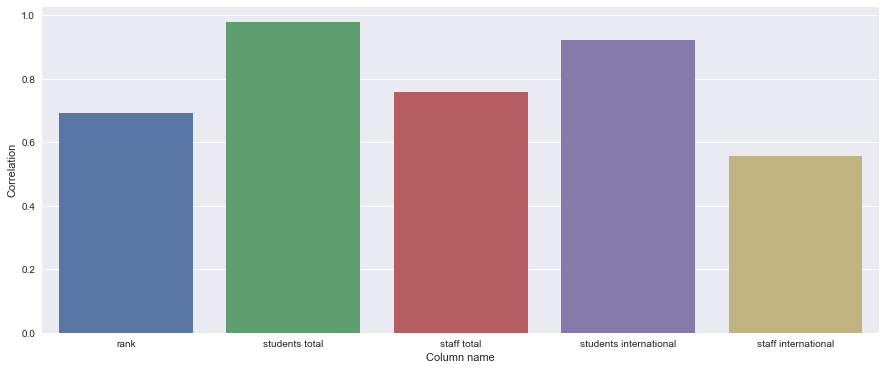

In [78]:
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 6)

import matplotlib.pyplot as plt
import seaborn as sns

corr_columns = [("rank_order", "rank_y"), ("students_total_x", "students_total_y"), ("staff_total_x", "staff_total_y"),
               ("students_international_x", "students_international_y"), ("staff_international_x", "staff_international_y")]
col_names = []
corrs = []
for col1, col2 in corr_columns:
    corr = joint_ranking[col1].corr(joint_ranking[col2])
    if col1.startswith("rank"):
        col_name = "rank"
    else:
        col_name = col1.split("_")[0] + " " + col1.split("_")[1]
    
    col_names.append(col_name)
    corrs.append(corr)

fig, ax = plt.subplots(1, 1)
sns.barplot(x=col_names, y=corrs, ax=ax)
ax.set(xlabel="Column name", ylabel="Correlation")
plt.show()

Here we see that the correlations for the number of students are almost 1 (especially the total number of students). The correlation for the international number of students is a little above 0.9 so we can conclude that the method of determining which student is "international" can be different in both cases sometimes even if, overall, it is approximately the same thing since it is almost 1.

However, the correlation numbers are quite low for the staff columns and especially for the international staff column. We see that for the total number of staff members it is a little above 0.75 so we can conclude that the two rankings did not choose that someone belongs to the staff category by the same criteria. Even worse, the international staff correlation is just a little above 0.55. We recall that this information was not present for the Times ranking so we created it using the ratio of international students and "hoping" it would give some precise results. Here we see it is not the case.

Now let's compare the rank in a ranking with all the other stats about students and staff numbers:

In [79]:
joint_ranking

,location_x,name,nid,rank_x,rank_order,students_total_x,stats_pc_intl_students,stats_student_staff_ratio,region_x,ratio_intl_students,students_international_x,staff_total_x,staff_international_x,location_y,rank_y,region_y,staff_international_y,staff_total_y,students_international_y,students_total_y
0,United Kingdom,University of Oxford,468,1,10,20409,38%,11.2,Europe,0.38,7755,1822,692,United Kingdom,6,Europe,2964.0,6750.0,7353.0,19720.0
1,United Kingdom,University of Cambridge,470,2,20,18389,35%,10.9,Europe,0.35,6436,1687,590,United Kingdom,5,Europe,2278.0,5490.0,6699.0,18770.0
2,United States,California Institute of Technology,128779,=3,30,2209,27%,6.5,North America,0.27,596,339,91,United States,4,North America,350.0,953.0,647.0,2255.0
3,United States,Stanford University,467,=3,40,15845,22%,7.5,North America,0.22,3485,2112,464,United States,2,North America,2042.0,4285.0,3611.0,15878.0
4,United States,Massachusetts Institute of Technology,471,5,50,11177,34%,8.7,North America,0.34,3800,1284,436,United States,1,North America,1679.0,2982.0,3717.0,11067.0
5,United States,Harvard University,466,6,60,20326,26%,8.9,North America,0.26,5284,2283,593,United States,3,North America,1311.0,4350.0,5266.0,22429.0
6,United States,Princeton University,469,7,70,7955,24%,8.3,North America,0.24,1909,958,229,United States,13,North America,246.0,1007.0,1793.0,8069.0
7,United Kingdom,Imperial College London,472,8,80,15857,55%,11.4,Europe,0.55,8721,1390,764,United Kingdom,8,Europe,2071.0,3930.0,8746.0,16090.0
8,United States,University of Chicago,473,9,90,13525,25%,6.2,North America,0.25,3381,2181,545,United States,9,North America,635.0,2449.0,3379.0,13557.0
9,Switzerland,ETH Zurich – Swiss Federal Institute of Techno...,479,=10,100,19233,38%,14.6,Europe,0.38,7308,1317,500,Switzerland,10,Europe,1886.0,2477.0,7563.0,19815.0


In [80]:
joint_ranking["staff_students_ratio_x"] = joint_ranking["stats_student_staff_ratio"].map(lambda number: 1 / number)
joint_ranking["staff_students_ratio_y"] = joint_ranking["staff_total_y"] / joint_ranking["students_total_y"]
joint_ranking["ratio_intl_students_x"] = joint_ranking["ratio_intl_students"]
joint_ranking["ratio_intl_students_y"] = joint_ranking["students_international_y"] / joint_ranking["students_total_y"]
joint_ranking["ratio_intl_staff_x"] = joint_ranking["staff_international_x"] / joint_ranking["staff_total_x"]
joint_ranking["ratio_intl_staff_y"] = joint_ranking["staff_international_y"] / joint_ranking["staff_total_y"]
joint_ranking = joint_ranking[["name", "region_x", "location_x", "rank_order", "students_total_x", "students_international_x", "staff_total_x", "staff_international_x", "staff_students_ratio_x", "ratio_intl_students_x", "ratio_intl_staff_x",
                                       "region_y", "location_y", "rank_y", "students_total_y", "students_international_y", "staff_total_y", "staff_international_y", "staff_students_ratio_y", "ratio_intl_students_y", "ratio_intl_staff_y"]]
joint_ranking["rank_order"] = pd.to_numeric(joint_ranking["rank_order"])
joint_ranking["rank_y"] = pd.to_numeric(joint_ranking["rank_y"])

/home/ahmed/python_libs/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ahmed/python_libs/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [81]:
joint_ranking

,name,region_x,location_x,rank_order,students_total_x,students_international_x,staff_total_x,staff_international_x,staff_students_ratio_x,ratio_intl_students_x,...,region_y,location_y,rank_y,students_total_y,students_international_y,staff_total_y,staff_international_y,staff_students_ratio_y,ratio_intl_students_y,ratio_intl_staff_y
0,University of Oxford,Europe,United Kingdom,10,20409,7755,1822,692,0.089286,0.38,...,Europe,United Kingdom,6,19720.0,7353.0,6750.0,2964.0,0.342292,0.372870,0.439111
1,University of Cambridge,Europe,United Kingdom,20,18389,6436,1687,590,0.091743,0.35,...,Europe,United Kingdom,5,18770.0,6699.0,5490.0,2278.0,0.292488,0.356899,0.414936
2,California Institute of Technology,North America,United States,30,2209,596,339,91,0.153846,0.27,...,North America,United States,4,2255.0,647.0,953.0,350.0,0.422616,0.286918,0.367261
3,Stanford University,North America,United States,40,15845,3485,2112,464,0.133333,0.22,...,North America,United States,2,15878.0,3611.0,4285.0,2042.0,0.269870,0.227422,0.476546
4,Massachusetts Institute of Technology,North America,United States,50,11177,3800,1284,436,0.114943,0.34,...,North America,United States,1,11067.0,3717.0,2982.0,1679.0,0.269450,0.335863,0.563045
5,Harvard University,North America,United States,60,20326,5284,2283,593,0.112360,0.26,...,North America,United States,3,22429.0,5266.0,4350.0,1311.0,0.193945,0.234785,0.301379
6,Princeton University,North America,United States,70,7955,1909,958,229,0.120482,0.24,...,North America,United States,13,8069.0,1793.0,1007.0,246.0,0.124799,0.222208,0.244290
7,Imperial College London,Europe,United Kingdom,80,15857,8721,1390,764,0.087719,0.55,...,Europe,United Kingdom,8,16090.0,8746.0,3930.0,2071.0,0.244251,0.543567,0.526972
8,University of Chicago,North America,United States,90,13525,3381,2181,545,0.161290,0.25,...,North America,United States,9,13557.0,3379.0,2449.0,635.0,0.180645,0.249244,0.259290
9,ETH Zurich – Swiss Federal Institute of Techno...,Europe,Switzerland,100,19233,7308,1317,500,0.068493,0.38,...,Europe,Switzerland,10,19815.0,7563.0,2477.0,1886.0,0.125006,0.381681,0.761405


Times ranking:

students_total_x : -0.15885765649801917
students_international_x : -0.3007930295697675
staff_total_x : -0.2487537327616549
staff_international_x : -0.39315218642139166
staff_students_ratio_x : -0.1416516889911341
ratio_intl_students_x : -0.20702384181393352
ratio_intl_staff_x : -0.20829005619490965


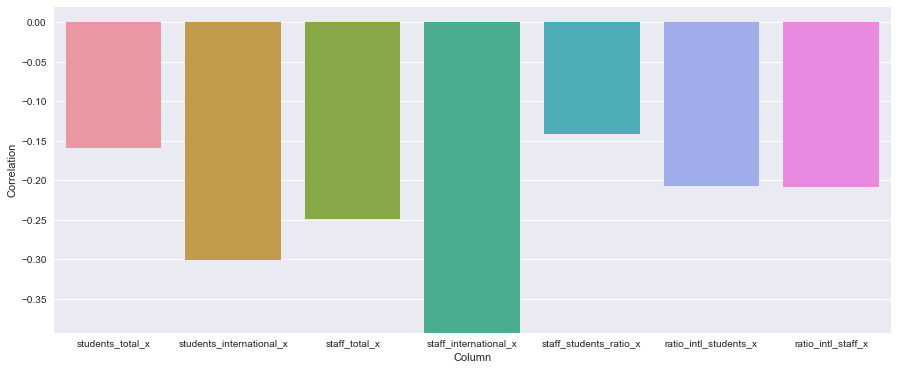

In [83]:
corr_cols = ["students_total_x", "students_international_x", "staff_total_x", "staff_international_x", "staff_students_ratio_x", "ratio_intl_students_x", "ratio_intl_staff_x"]
corrs_qs_rank = []
for col in corr_cols:
    corr = joint_ranking["rank_order"].corr(joint_ranking[col])
    print("{} : {}".format(col, corr))
    corrs_qs_rank.append(corr)

fig, ax = plt.subplots(1, 1)
sns.barplot(x = corr_cols, y = corrs_qs_rank, ax=ax)
ax.set(xlabel="Column", ylabel="Correlation")
plt.show()

QS Ranking:

students_total_y : -0.04324109113777754
students_international_y : -0.2579783462986618
staff_total_y : -0.3830103158839833
staff_international_y : -0.5072337235517727
staff_students_ratio_y : -0.43008702941191457
ratio_intl_students_y : -0.2984291643807952
ratio_intl_staff_y : -0.29120815630072744


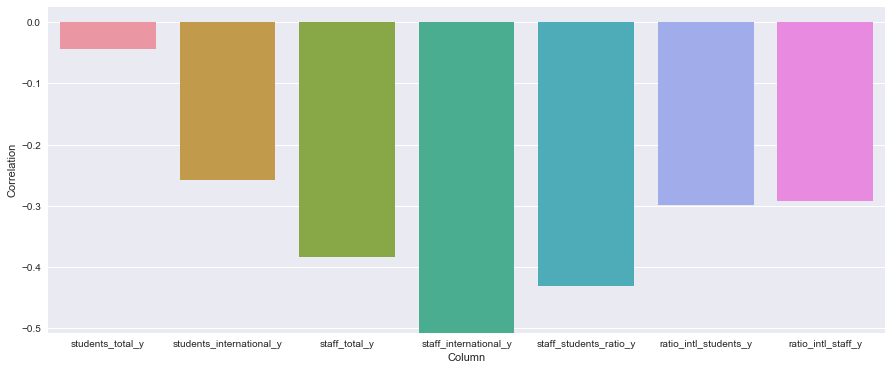

In [84]:
corr_cols = ["students_total_y", "students_international_y", "staff_total_y", "staff_international_y", "staff_students_ratio_y", "ratio_intl_students_y", "ratio_intl_staff_y"]
corrs_qs_rank = []
for col in corr_cols:
    corr = joint_ranking["rank_y"].corr(joint_ranking[col])
    print("{} : {}".format(col, corr))
    corrs_qs_rank.append(corr)

fig, ax = plt.subplots(1, 1)
sns.barplot(x = corr_cols, y = corrs_qs_rank, ax=ax)
ax.set(xlabel="Column", ylabel="Correlation")
plt.show()

### Discussion
Here we see that all those correlations are negative for both rankings. The reason is simply because the ranking is in ascending order. The total number of students has a quite weak correlation with the ranking (even if there is some, we can say that the number of students is not an indicator of the ranking). However, the ratio of international students and staff members both show a stronger correlation than the number of students. This obviousl y means that universities which are better in ranking attract more people from other countries. Now, the total number of staff members also shows a stronger correlation, which indicates that universities which are better in ranking have more people (probably more money also). Similar conclusions can be drawn for international staff members.

In [ ]:
joint_ranking.rank_order = joint_ranking.rank_order.astype(int)
joint_ranking.rank_y = joint_ranking.rank_y.astype(int)

In [ ]:
joint_ranking.rank_order.corr(joint_ranking.rank_y)

In [ ]:
joint_ranking.stats_number_students = joint_ranking.stats_number_students.map(lambda number : number.replace(",", "")).astype(int)
joint_ranking.students_total = joint_ranking.students_total.astype(int)

In [ ]:
joint_ranking.stats_number_students.corr(joint_ranking.students_total)